<a href="https://colab.research.google.com/github/lakatosgabor/magyar_modszer/blob/main/Magyar_m%C3%B3dszer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import random
import time

def get_operators():
  #itt kérdezem le a bent lévő opeártorokat
  operators = ['Operator 1', 'Operator 2', 'Operator 3', 'Operator 4', 'Operator 5', 'Operator 6', 'Operator 7', 'Operator 8', 'Operator 9', 'Operator 10']

  return operators

def get_products():
  #itt kérdezem le, hogy mely termékeket kell gyártani
  #ha egy termék több operátoros az többször kerül be a listába
  products = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
  return products

def get_efficiency_matrix(operators, products):
  #itt kell lekérdezni az operátorok hatékonyságát az adott termékre
  EFFICIENCY = np.array([
    [110, 85, 90, 100, 90, 95, 99, 97, 70, 0],
    [105, 110, 95, 100, 90, 95, 98, 98, 80, 0],
    [102, 105, 100, 90, 95, 99, 97, 90, 70, 0],
    [101, 102, 101, 90, 95, 98, 98, 100, 80, 0],
    [100, 101, 102, 100, 90, 95, 99, 97, 70, 0],
    [99, 100, 105, 100, 90, 95, 98, 98, 80, 0],
    [98, 99, 110, 90, 95, 98, 97, 90, 70, 0],
    [95, 98, 85, 90, 95, 99, 98, 100, 80, 0],
    [90, 95, 90, 100, 90, 95, 99, 97, 0,70],
    [85, 90, 95, 100, 90, 95, 98, 98, 80, 0]
])

  EFFICIENCY = EFFICIENCY.astype(float)

  EFFICIENCY = to_square_matrix(EFFICIENCY)

  return EFFICIENCY

def to_square_matrix(matrix):
    rows, cols = matrix.shape
    if rows == cols:
        return matrix

    # Ha nem négyzetes, átalakítjuk
    n = max(rows, cols)
    square_matrix = np.zeros((n, n), dtype=matrix.dtype)
    square_matrix[:rows, :cols] = matrix
    return square_matrix

def get_monotony_matrix(operators, products):
  #ide jön a monotonítás lekérdezése

  monotony = np.array([
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  ])

  monotony = monotony.astype(float)

  return to_square_matrix(monotony)

def pertubation(EFFICIENCY):
    rows, cols = EFFICIENCY.shape
    for col in range(cols):
        for row in range(rows):
            # Alapérték átalakítás és kis véletlenszerű eltérés hozzáadása, egy megadott tartományban generál kis véletlen eltéréseket
            EFFICIENCY[row, col] = ((EFFICIENCY[row, col] // 3) * 3) + np.random.uniform(-0.5, 0.5)
    return EFFICIENCY

def to_constraints_matrix(operators, products, COST):
  #adatbázisból kérdezzül le
  constraints_matrix = np.array([
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  ])

  constraints_matrix = constraints_matrix.astype(float)

  constraints_matrix = to_square_matrix(constraints_matrix)

  # Megkeressük az összes 0 értéket a constraints_matrix-ban
  zero_indices = np.where(constraints_matrix == 0)

  # Az azonos indexű elemeket a H mátrixban inf-re állítjuk
  COST[zero_indices] = 10000

  return COST

def cost_matrix(EFFICIENCY):
  max_value = np.max(EFFICIENCY)
  EFFICIENCY = max_value - EFFICIENCY

  return EFFICIENCY

def run_hungarian_algorithm(operators, products, COST):
  row_ind, col_ind = linear_sum_assignment(COST)
  assignments = [(operators[i], products[j]) for i, j in zip(row_ind, col_ind)]

  return assignments


############### RUN PROCESS ###############
start_time = time.time()

operators = get_operators()

products = get_products()

EFFICIENCY = get_efficiency_matrix(operators, products)

MONOTONY = get_monotony_matrix(operators, products)

EFFICIENCY = EFFICIENCY * MONOTONY

EFFICIENCY = pertubation(EFFICIENCY)

COST = cost_matrix(EFFICIENCY)

COST = to_constraints_matrix(operators, products, COST)

assignments = run_hungarian_algorithm(operators, products, COST)

# Számláló inicializálása
counter = 1

# Először kiírjuk a nem 0 értékű párokat
for operator, product in assignments:
    if product != 0:
        print(f"{counter}) {operator} : {product}")
        counter += 1

# Ezután kiírjuk a 0 értékű párokat, ha van
for operator, product in assignments:
    if product == 0:
        print(f"{counter}) {operator} : {product}")
        counter += 1


# Mérés vége
end_time = time.time()
execution_time = end_time - start_time  # Futási idő másodpercekben
execution_time_minutes = execution_time / 60  # Futási idő percekben

print(f"\nA kód {execution_time_minutes:.6f} percig futott.")

1) Operator 1 : A
2) Operator 2 : B
3) Operator 3 : F
4) Operator 4 : H
5) Operator 5 : G
6) Operator 6 : I
7) Operator 7 : C
8) Operator 8 : E
9) Operator 9 : J
10) Operator 10 : D

A kód 0.000021 percig futott.


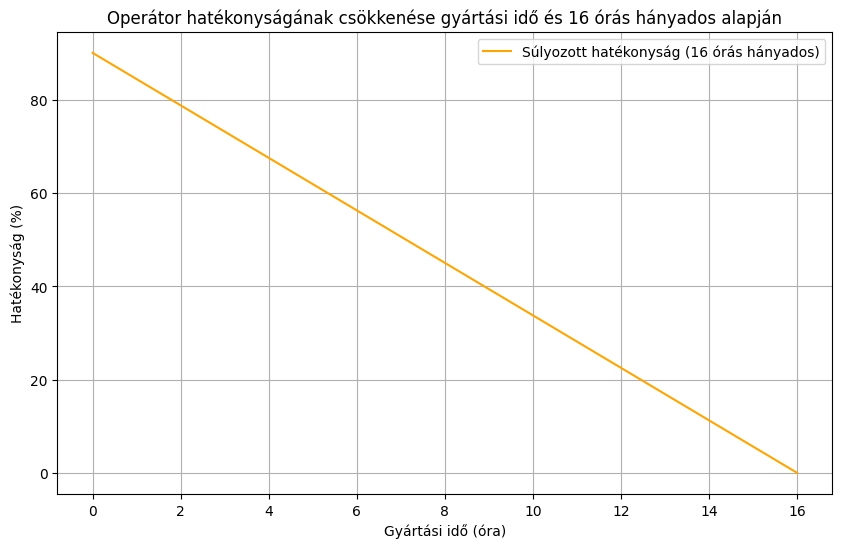

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Új megközelítés, ahol a gyártási idő hányadosát 16 órával súlyozzuk a hatékonyságra
def sulyozott_hatekonysag_hanyados(hatekonysag, t, max_ido=16):
    # A gyártási idő hányadosával csökkentjük a hatékonyságot
    hanyados = min(t / max_ido, 1)  # Ügyeljünk arra, hogy ne lépje túl az 1-et
    return hatekonysag * (1 - hanyados)

kezdeti_hatekonysag = 90
gyartasi_ido = np.linspace(0, 16, 100)
# Súlyozott hatékonyság kiszámítása minden időpontra az új hányados alapú képlettel
sulyozott_hatekonysag_hanyados_values = [sulyozott_hatekonysag_hanyados(kezdeti_hatekonysag, t) for t in gyartasi_ido]


# Grafikon készítése
plt.figure(figsize=(10, 6))
plt.plot(gyartasi_ido, sulyozott_hatekonysag_hanyados_values, label="Súlyozott hatékonyság (16 órás hányados)", color="orange")
plt.xlabel("Gyártási idő (óra)")
plt.ylabel("Hatékonyság (%)")
plt.title("Operátor hatékonyságának csökkenése gyártási idő és 16 órás hányados alapján")
plt.grid(True)
plt.legend()
plt.show()

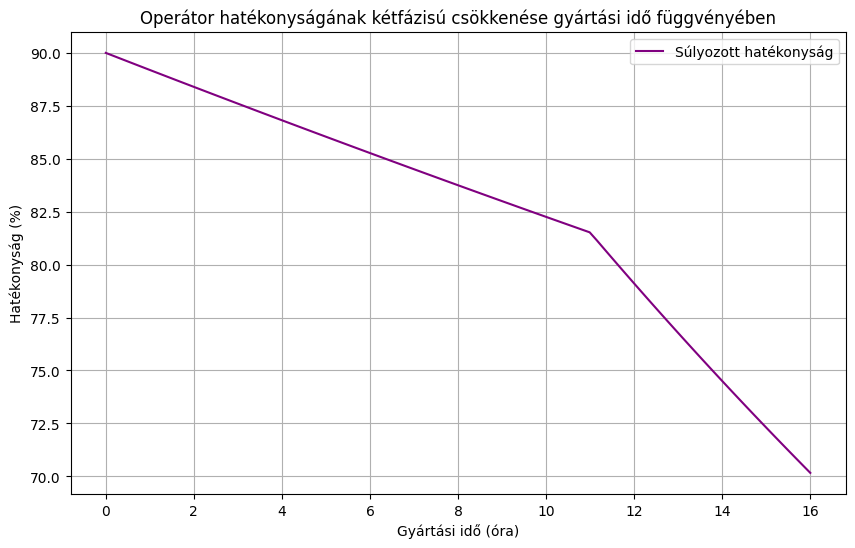

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def sulyozott_hatekonysag_ketfazisu(hatekonysag, t, lambd1=0.009, lambd2=0.03, threshold=11):
    if t <= threshold:
        return hatekonysag * np.exp(-lambd1 * t)
    else:
        return hatekonysag * np.exp(-lambd1 * threshold) * np.exp(-lambd2 * (t - threshold))

kezdeti_hatekonysag = 90
gyartasi_ido = np.linspace(0, 16, 100)

# Súlyozott hatékonyság kiszámítása minden időpontra az új kétfázisú képlettel
sulyozott_hatekonysag_ketfazisu_values = [sulyozott_hatekonysag_ketfazisu(kezdeti_hatekonysag, t) for t in gyartasi_ido]

gyartasi_ido = np.linspace(0, 16, 100)


# Grafikon készítése
plt.figure(figsize=(10, 6))
plt.plot(gyartasi_ido, sulyozott_hatekonysag_ketfazisu_values, label="Súlyozott hatékonyság", color="purple")
plt.xlabel("Gyártási idő (óra)")
plt.ylabel("Hatékonyság (%)")
plt.title("Operátor hatékonyságának kétfázisú csökkenése gyártási idő függvényében")
plt.grid(True)
plt.legend()
plt.show()


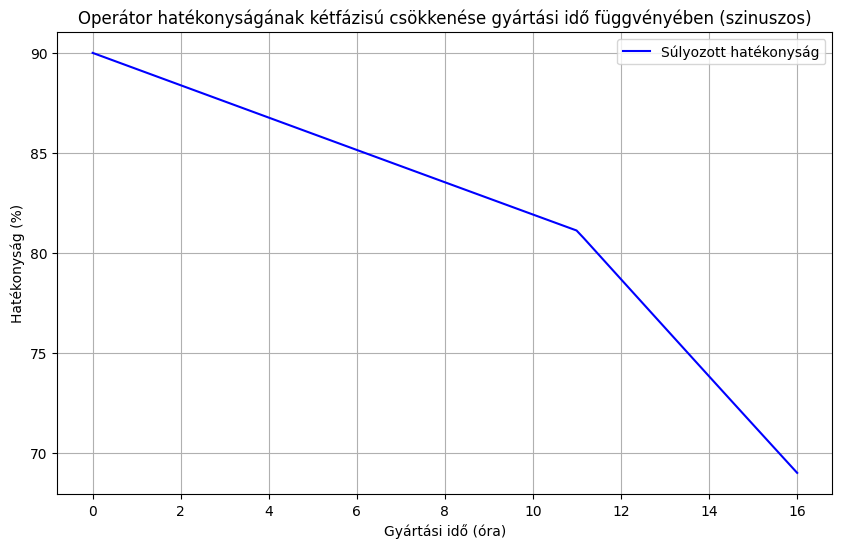

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def sulyozott_hatekonysag_ketfazisu(hatekonysag, t, lambd1=0.009, lambd2=0.03, threshold=11):
    # Kisebb változás 0-8 óra között, erősebb változás 8 óra után
    if t <= threshold:
        return hatekonysag * (1 - np.sin(lambd1 * t))
    else:
        return hatekonysag * (1 - np.sin(lambd1 * threshold)) * (1 - np.sin(lambd2 * (t - threshold)))

kezdeti_hatekonysag = 90
gyartasi_ido = np.linspace(0, 16, 100)

# Súlyozott hatékonyság kiszámítása minden időpontra az új kétfázisú képlettel
sulyozott_hatekonysag_ketfazisu_values = [sulyozott_hatekonysag_ketfazisu(kezdeti_hatekonysag, t) for t in gyartasi_ido]

# Grafikon készítése
plt.figure(figsize=(10, 6))
plt.plot(gyartasi_ido, sulyozott_hatekonysag_ketfazisu_values, label="Súlyozott hatékonyság", color="blue")
plt.xlabel("Gyártási idő (óra)")
plt.ylabel("Hatékonyság (%)")
plt.title("Operátor hatékonyságának kétfázisú csökkenése gyártási idő függvényében (szinuszos)")
plt.grid(True)
plt.legend()
plt.show()
